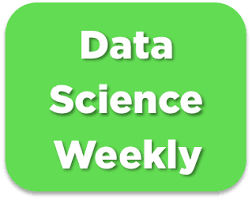

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

from sklearn.metrics import (
    f1_score, 
    classification_report,
    ConfusionMatrixDisplay,
    recall_score,
    RocCurveDisplay)

import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
data = pd.read_csv("datas/conversion_data_train_EDA.csv")

In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## XGBoost

In [4]:
target = "converted"

x = data.drop(target, axis = 1) 
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
numerical_columns = x_train.select_dtypes(include=["float", "int"]).columns
categorical_columns = x_train.select_dtypes(include="object").columns

display(x.head())
print("y :", y)
print("numerical_columns :", numerical_columns)
print("categorical_columns :", categorical_columns)

,country,age,new_user,source,total_pages_visited
0,China,22,1,Direct,2
1,UK,21,1,Ads,3
2,Germany,20,0,Seo,14
3,US,23,1,Seo,3
4,US,28,1,Direct,3


y : 0         0
1         0
2         1
3         0
4         0
         ..
283558    0
283559    0
283560    0
283561    0
283562    0
Name: converted, Length: 283563, dtype: int64
numerical_columns : Index(['age', 'new_user', 'total_pages_visited'], dtype='object')
categorical_columns : Index(['country', 'source'], dtype='object')


In [6]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(
    steps=[
    ("encoder", OneHotEncoder(drop="first"))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_columns)
    ])

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

In [7]:
from sklearn.utils.class_weight import compute_sample_weight

xgboost = XGBClassifier()

params = {
    "max_depth": [10, 15],
    "min_child_weight": [1, 5, 10],
    "n_estimators": [200]
}

grid_search = GridSearchCV(xgboost, param_grid=params, cv=3, scoring="recall")
sample_weights = compute_sample_weight(class_weight={0: 1, 1: 2}, y=y_train)
grid_search.fit(x_train, y_train, sample_weight=sample_weights)

print("Best hyperparameters : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

Best hyperparameters :  {'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 200}
Best score :  0.7461161079313164


In [8]:
y_train_pred = grid_search.best_estimator_.predict(x_train)
y_test_pred = grid_search.best_estimator_.predict(x_test)

In [9]:
print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

f1-score on training set :  0.7897520434095748
f1-score on test set :  0.7615638766519823

recall_score on training set :  0.7834559825565549
recall_score on test set :  0.7536784741144414


In [10]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    219512
           1       0.80      0.78      0.79      7338

    accuracy                           0.99    226850
   macro avg       0.89      0.89      0.89    226850
weighted avg       0.99      0.99      0.99    226850



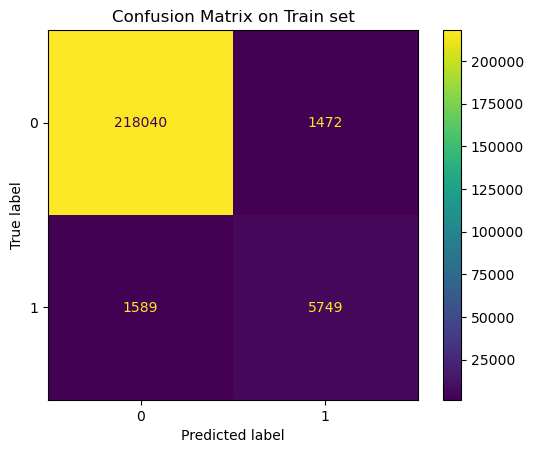

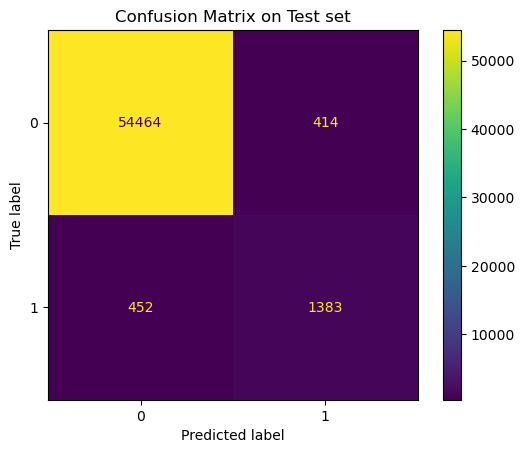

In [11]:
# Visualize confusion matrices
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, x_train, y_train, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="Confusion Matrix on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_, x_test, y_test, ax=ax
)  # ConfusionMatrixDisplay from sklearn
plt.show()

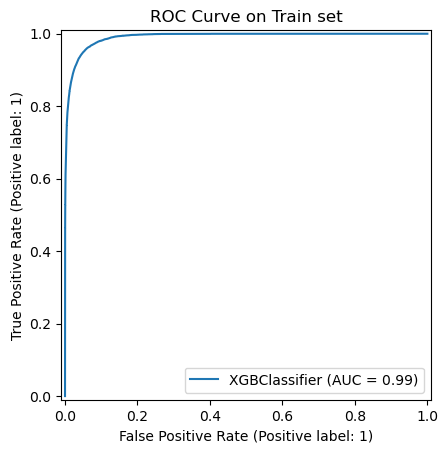

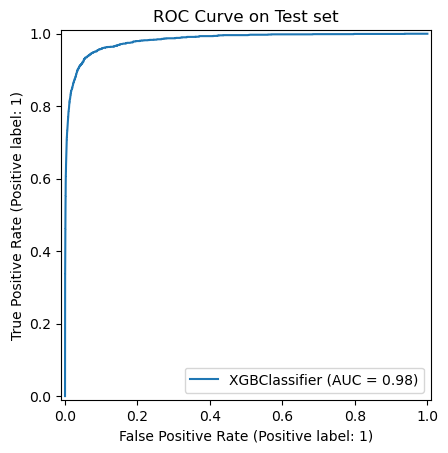

In [12]:
# Visualize ROC curves
_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Train set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    grid_search.best_estimator_, x_train, y_train, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

_, ax = plt.subplots()  # Get subplot from matplotlib
ax.set(
    title="ROC Curve on Test set"
)  # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(
    grid_search.best_estimator_, x_test, y_test, ax=ax
)  # RocCurveDisplay from sklearn
plt.show()

---

Analyse des coefficients

In [13]:
column_names = []
for (
    name,
    step,
    features_list,
) in preprocessor.transformers_:  # loop over steps of ColumnTransformer
    if name == "num":  # if pipeline is for numeric variables
        features = (
            features_list  # just get the names of columns to which it has been applied
        )
    else:  # if pipeline is for categorical variables
        features = (
            step.get_feature_names_out()
        )  # get output columns names from OneHotEncoder
    column_names.extend(features)  # concatenate features names
     
# Create a pandas DataFrame
feature_importance = pd.DataFrame(
    index=column_names,
    data=grid_search.best_estimator_.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")

In [14]:
# Plot coefficients
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, margin={"l": 120}  # to avoid cropping of column names
)
fig.show()

La colonne `total_pages_visited` est très importante à la prédiction, je vais la multiplier

In [15]:
data["total_pages_visited_2"] = data["total_pages_visited"] * data["total_pages_visited"]
data["total_pages_visited_3"] = data["total_pages_visited"] * data["total_pages_visited"] * data["total_pages_visited"]
data["total_pages_visited_4"] = data["total_pages_visited"] * data["total_pages_visited"] * data["total_pages_visited"] * data["total_pages_visited"]
data["total_pages_visited_inverse"] = 1 / data["total_pages_visited"]
data["total_pages_visited_inverse_2"] = 1 / (data["total_pages_visited"] * data["total_pages_visited"])

target = "converted"

x = data.drop(target, axis = 1) 
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.transform(x_test)

grid_search.best_estimator_.fit(x_train, y_train, sample_weight=sample_weights)

print("Best hyperparameters : ", grid_search.best_params_)
print("Best score : ", grid_search.best_score_)

y_train_pred = grid_search.best_estimator_.predict(x_train)
y_test_pred = grid_search.best_estimator_.predict(x_test)

print("f1-score on training set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))
print()
print("recall_score on training set : ", recall_score(y_train, y_train_pred))
print("recall_score on test set : ", recall_score(y_test, y_test_pred))

Best hyperparameters :  {'max_depth': 10, 'min_child_weight': 10, 'n_estimators': 200}
Best score :  0.7461161079313164
f1-score on training set :  0.7897520434095748
f1-score on test set :  0.7615638766519823

recall_score on training set :  0.7834559825565549
recall_score on test set :  0.7536784741144414


---

## make predictions on X_without_labels

In [ ]:
# Read data without labels
data_without_labels = pd.read_csv("datas/conversion_data_test_EDA.csv")
data_without_labels["total_pages_visited_2"] = data_without_labels["total_pages_visited"] * data_without_labels["total_pages_visited"]
data_without_labels["total_pages_visited_3"] = data_without_labels["total_pages_visited"] * data_without_labels["total_pages_visited"] * data_without_labels["total_pages_visited"]
data_without_labels["total_pages_visited_4"] = data_without_labels["total_pages_visited"] * data_without_labels["total_pages_visited"] * data_without_labels["total_pages_visited"] * data_without_labels["total_pages_visited"]
data_without_labels["total_pages_visited_inverse"] = 1 / data_without_labels["total_pages_visited"]
data_without_labels["total_pages_visited_inverse_2"] = 1 / (data_without_labels["total_pages_visited"] * data_without_labels["total_pages_visited"])

x_without_labels = data_without_labels

x_without_labels = preprocessor.transform(x_without_labels)
y_pred_without_label = grid_search.best_estimator_.predict(x_without_labels)

# Read target without labels
y_without_labels = pd.read_csv("datas/conversion_data_test_labels_EDA.csv")

print("f1-score on set without labels : ", f1_score(y_without_labels, y_pred_without_label))
print()
print("recall_score on set without labels : ", recall_score(y_without_labels, y_pred_without_label))

f1-score on set without labels :  0.7416291854072964

recall_score on set without labels :  0.7295968534906588


Sauvegarde de tous les résultats dans un dataframe

In [ ]:
scores_df = pd.DataFrame(columns = ["model", "f1", "recall"])

new_rows = [
    {"model": "XGBoost", "f1": f1_score(y_without_labels, y_pred_without_label), "recall": recall_score(y_without_labels, y_pred_without_label)}
]

scores_df = pd.concat([scores_df, pd.DataFrame(new_rows)], ignore_index=True)
scores_df.to_csv("datas/scores.csv", mode="a", header=False, index=False)

C:\Users\janda\AppData\Local\Temp\ipykernel_11416\4101235088.py:7: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

